In [ ]:
!pip install fastai

In [2]:
import fastai
import torch

In [43]:
from fastcore.all import *
from fastdownload import download_url
import time

from fastai.vision.all import *
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [12]:
?download_images

In [ ]:
# Using search images 

In [8]:
def search_images(term, max_images=200):
        url = 'https://duckduckgo.com/'
        res = urlread(url, data={'q':term})
        searchObj = re.search(r'vqd=([\d-]+)\&', res)
        requestUrl = url + 'i.js'
        params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f='...', p='1', v7exp='a')
        urls, data = set(), {'next':1}
        while len(urls)<max_images and 'next' in data:
            data = urljson(requestUrl, data=params)
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
            time.sleep(0.2)
        return L(urls)[:max_images]

In [6]:
terms = ['hotdog', 'pasta', 'pizza', 'salad', 'sandwich']
urls = search_images('hotdog')

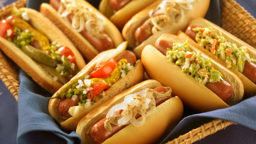

In [9]:
dest = 'hotdog.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256, 256)

In [92]:
searches = 'hotdog', 'pasta', 'pizza', 'salad', 'sandwich'
test_img = Path('hotdogData')

for o in searches:
    dest = (path/o)
    if os.path.exists(dest) == False:
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{o} photo'), max_pics=200)
        resize_images(path/o, max_size=400, dest=path/o)                  

In [81]:
# Manual
class HotDogDataset(Dataset):
    def __init__(self, searches, transform):
        self.path = Path('hotdogData')
        self.list_paths = []
        for tag in searches:
            if (os.path.exists(path/tag)) & (tag.endswith('jpg')==False):
                tags_dir = os.listdir(path/tag)
                tags_dir = [f'{path/tag/t}' for t in tags_dir if 'checkpoints' not in t ]
                self.list_paths.extend(tags_dir)

    def __len__(self):
        return len(self.list_paths)
    
    def __getitems__(self, index):
        dest = self.list_paths[index]
        x = Image.open(dest)
        y = dest.split(os.sep)[1]
        print(y)
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

dt = HotDogDataset(searches, transform=transform)

delete_images = verify_images(dt.list_paths)

print(f'deleting {len(delete_images)}')
for d_img in delete_images:
    Path(d_img).unlink()

train_size = int(0.8 * len(dt))
test_size = len(dt) - train_size

train_dataset, test_dataset = random_split(dt, [train_size, test_size])

train_data = DataLoader(dataset=train_dataset, batch_size=6, shuffle=True)

deleting 0


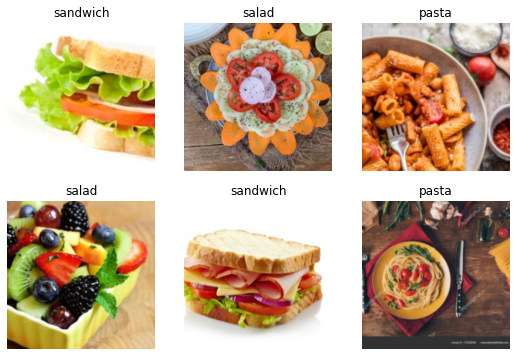

In [93]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='crop')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.559188,0.342506,0.116022,00:20


epoch,train_loss,valid_loss,error_rate,time


In [ ]:
y_pred, _, probs = learn.predict(PILImage.create('hotdog.jpg'))

print(probs[], _, probs)

In [ ]:
max(probs)